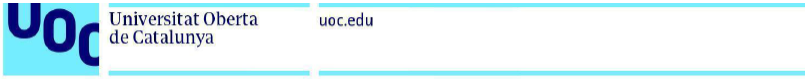

# Práctica 2: Limpieza y análisis de datos

**Asignatura**: Tipología y ciclo de vida de los datos (Máster Ciencia de Datos)

**Alumnos**:


*   Nicolás C. Caruso
*   Antonio Gutiérrez Blanco

Para la presente práctica, se ha utilizado el siguiente dataset: https://www.kaggle.com/c/titanic/data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# Tests estadísticos
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm

# Representación gráfica
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

file_name = "drive/MyDrive/PRA2 - Tipología/titanic_data.csv"

# Cargamos y mostramos los datos
data = pd.read_csv(file_name)
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# 1. Descripción del dataset

¿Por qué es importante y qué pregunta/problema pretende responder?


El Titanic fue un transatlántico británico que se hundió en el Atlántico Norte en la madrugada del 15 de abril de 1912, tras colisionar con un iceberg durante su viaje inaugural de Southampton a Nueva York. Se calcula que había 2224 pasajeros y tripulantes a bordo del barco, y que murieron más de 1500, lo que lo convierte en uno de los desastres marítimos comerciales más grandes de la historia moderna. El Titanic era el mayor barco a flote en el momento en que entró en servicio y fue el segundo de los tres transatlánticos de clase olímpica operados por la White Star Line.

El dataset elegido contiene información demográfica y de los pasajeros de 891 de los 2224 pasajeros y tripulantes a bordo del Titanic. Cabe destacar que el dataset no contiene los datos de todos los pasajeros que abordaron el barco. El dataset de entrenamiento contiene 891 registros. La información contenida en este dataset resulta útil para investigar ls factore que determinaron la probabilidad de supervivencia al hundimiento del Titanic.

Variables:

*   Survived: valor booleano que indica si el pasajero sobrevivió o no. El valor 0 indica que no sobrevivió y 1 indica que sí.
*   Pclass: Categoría en la que viajaba el pasajero (un proxy de su clase social).   
*   Sex: sexo del pasajero.
*   Age: edadd del pasajero.
*   Sibsp: número de hermanos o cónyuges a bordo del Titanic.
*   Parch: número de padres o hijos a bordo del Titanic.
*   Ticket: número de boleto.
*   Fare: tarifa del pasajero.
*   Cabin: número de cabina.
*   Embarked: puerto de embarque.

Puesto que la mayoría de análisis realizados que se pueden encontrar en la web pretenden analizar la probabilidad de supervivencia de los pasajeros, en nuestro caso vamos a tratar de dar respuesta a preguntas del tipo:


*   ¿El lugar en el que embarcó el pasajero tiene relación con el precio del billete?
*   ¿Cuál es la influencia del sexo en el precio del billete?
* ¿Qué influye más en la probabilidad de supervivencia, el precio del billete o la edad del pasajero?











# 2. Integración y selección de los datos de interés a analizar

Pese a que con la información de la cabina posiblemente se podría construir nuevos atributos (feature engineering), en nuestro caso descartaremos tanto el identificador del pasajero y como el de la cabina ya que no aportan valor al análisis.

In [4]:
# Columnas que no son útiles (para descartar)
drop_cols = ["PassengerId", "Cabin"]

data = data.drop(columns=drop_cols)

# 3. Limpieza de datos

En esta etapa, trataremos de realizar imputaciones en aquellos registros con valores ausentes y corregiremos las posibles anomalías (ouliers) que detectemos.

## 3.1. ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?

In [5]:
# Podemos mostrar una descripción general del dataset
data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,3
top,NaN,NaN,"Sjoblom, Miss. Anna Sofia",male,NaN,NaN,NaN,CA. 2343,NaN,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN


In [6]:
# Podemos inspeccionar las columnas que tienen valores nulos y la cantidad de valores faltantes por columna
MissD=pd.DataFrame(data.isna().any())
MissD.columns=['Missing data?']
MissD['#Missing data']=data.isna().sum()
MissD.T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
Missing data?,False,False,False,False,True,False,False,False,False,True
#Missing data,0,0,0,0,177,0,0,0,0,2


In [7]:
# para el caso de la edad podemos reemplazar los valores faltantes por el promedio de los datos disponibles
data_alt=data
data['Age'] = data['Age'].fillna(data['Age'].mean())


In [9]:
# alternativamente podemos utilizar el algoritmo k-nearest neighbors para imputar los valore perdidos de Age.
# en este caso se utiliza también la media, pero de los N valores más cercanos.

from sklearn.impute import KNNImputer

# Construimos el modelo
imputer = KNNImputer(n_neighbors=5, weights="uniform")


# Ajustamos el modelo e imputamos los missing values
imputer.fit(data_alt[["Age"]])
data_alt["Age"] = imputer.transform(data_alt[["Age"]]).ravel()

In [ ]:
# Para el caso del puerto de embarque solo hay dos datos faltantes así que podemos completarlo con el valor más frecuente (moda)

data['Embarked']=data['Embarked'].fillna(data['Embarked'].value_counts().index[0])

In [31]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
# vuelvo a comprobar los valores faltantes
MissD=pd.DataFrame(data.isna().any())
MissD.columns=['Missing data?']
MissD['#Missing data']=data.isna().sum()
MissD.T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
Missing data?,False,False,False,False,False,False,False,False,False,False
#Missing data,0,0,0,0,0,0,0,0,0,0


## 3.2. Identificación y tratamiento de valores extremos

### 3.2.1. Edad

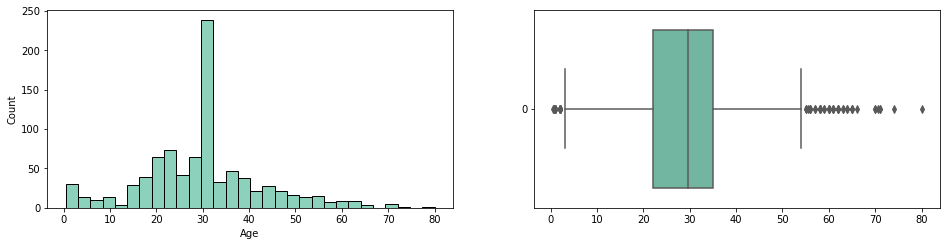

In [ ]:
# visualizamos la distribución de los datos a través de un histograma y un boxplot

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Age'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Age'], orient='h')
plt.show()

A partir del boxplot podemos ver que hay algunos valores que podrían interpretarse como outliers. Como la distribución es aproximadamente normal y, además, aplicando el TCL podemos asumir normalidad; vamos a aplicar un método de detección de outliers basado en la ditribución normal:

Aquellos punto que se encuentren por debajo de `mean-3*(sigma)` o por encima de `mean+3*(sigma)` serán considerados outliers y serán reemplazados por el valor límite en cada caso.


In [ ]:
upper_limit = data['Age'].mean() + 3*data['Age'].std()
lower_limit = data['Age'].mean() - 3*data['Age'].std()

print(round(upper_limit,0))
print(round(lower_limit,0))

69.0
-9.0


In [ ]:
# imputación de los datos

data['Age'] = np.where(
    data['Age']>upper_limit,
    upper_limit,
    np.where(
        data['Age']<lower_limit,
        lower_limit,
        data['Age']
    )
)

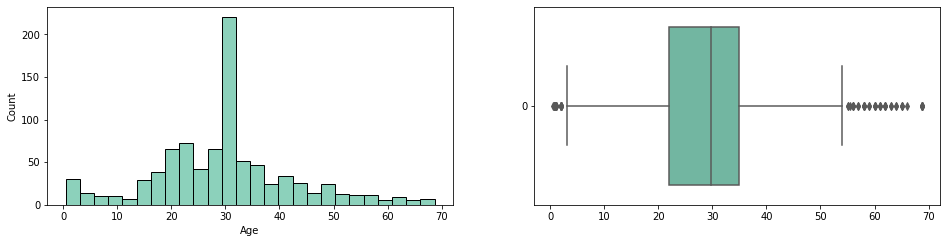

In [ ]:
# Volvemos a visualizar los datos corregidos

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Age'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Age'], orient='h')
plt.show()

### 3.2.1. Fare

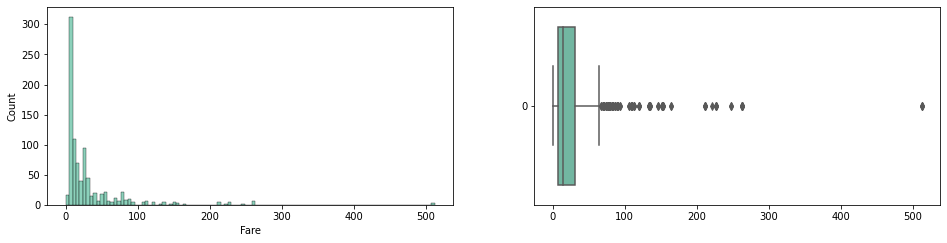

In [ ]:
# visualizamos la distribución de los datos a través de un histograma y un boxplot

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Fare'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Fare'], orient='h')
plt.show()

En el caso de la tarifa del boleto vemos, a partir del boxplot, que hay valores muy extremo. Sin embargo, contrariamente a lo que sucedía con la variable edad, en este caso la distribución está sesgada y no parece seguir una normal; por lo cual deberemos aplicar un método distinto. Para estos casos podemos utilizar la regla del rango intercuartílico (IRQ):

Los datos que caen por debajo de `Q1 – 1.5 IQR` o por encima de `Q3 + 1.5 IQR` serán considerado outliers. Q1 y Q3  representan el percentil 25 y 50, respectivamente; y IQR representa el rango intercuartílico calculado como `Q3 – Q1`.

In [ ]:
# calculo Q1, Q3 y el IQR

percentile25 = data['Fare'].quantile(0.25)
percentile75 = data['Fare'].quantile(0.75)
iqr=percentile75-percentile25

print(percentile25)
print(percentile75)
print(iqr)

7.9104
31.0
23.0896


In [ ]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [ ]:
# imputación de los datos

data['Fare'] = np.where(
    data['Fare'] > upper_limit,
    upper_limit,
    np.where(
        data['Fare'] < lower_limit,
        lower_limit,
        data['Fare']
    )
)

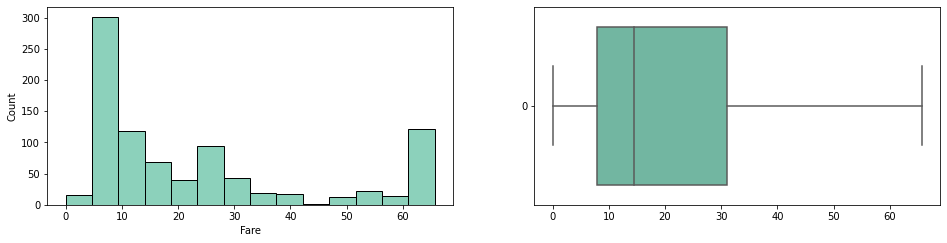

In [ ]:
# Visualizo nuevamente los datos

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(data['Fare'])
plt.subplot(2,2,2)
sns.boxplot(data=data['Fare'], orient='h')
plt.show()

# 4. Análisis de los datos

## 4.1. Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar)

En este punto vamos a comparar diferentes grupos de datos.

1. Medidas de tendencia central y dispersión de los atributos numéricos del dataset (Análisis estadístico descriptivo).

2. Analizar si existen diferencias significativas entre el precio medio (*Fare*) de hombres y mujeres (Comparación de dos grupos, análisis estadístico inferencial).

3. Correlación entre la edad y la tarifa (correlación de pearson, análisis estadístico inferencial).

4. Analizar si existen diferencias significativas entre las tarifas (*Fare*) en función del puerto de embarque (*Embarked*) (Comparación de varios grupos, análisis estadístico inferencial).

5. Regresión logística para ver si existe relación entre los grupos supervivientes/fallecidos y la edad y tarifa.

## 4.2. Comprobación de la normalidad y homogeneidad de la varianza

### 4.2.1. Normalidad

- **Tarifa (*Fare*)**: Puesto que p-value es menor que 0.05, podemos rechazar la hipótesis nula H0, por lo que no podemos asumir nomalidad en la distribución de la tarifa (Fare). **No obstante, puesto que el conjunto de datos se compone de un número de registros
suficientemente grande, por el teorema central del límite podemos considerar que los datos siguen una distribución normal**.

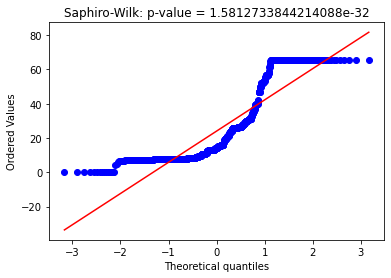

In [ ]:
# Tarifa (Fare)
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(data.Fare, plot=ax)

# Test de Shapiro-Wilk -> p-value
p_value = stats.shapiro(data.Fare)[1]

_ = ax.set_title("Saphiro-Wilk: p-value = {}".format(p_value))

- **Edad (*Age*)**: vemos que no podemos asumir normalidad ya que el p-value resultante del test es menor al nivel de significancia (0.05) y por tanto podemos descartar la hipótesis nula de normalidad de los datos. Sin embargo, por el TCL vamos a asumir normalidad.

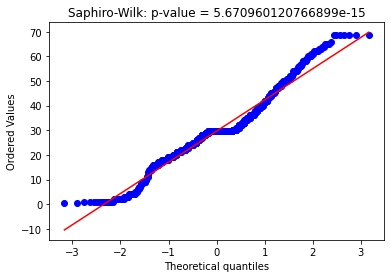

In [ ]:
# Edad
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(data.Age, plot=ax)

# Test de Shapiro-Wilk -> p-value
p_value = stats.shapiro(data.Age)[1]

_ = ax.set_title("Saphiro-Wilk: p-value = {}".format(p_value))

### 4.2.2. Comprobación homogeneidad de varianzas

*   **Género (*Sex*)**: realizamos el test de Levene para contrastar si existe igualdad de varianza. En este caso obtenemos que p-value < 0.05, por lo que podemos descartar H0 y no asumimos igualdad de varianza.



In [ ]:
# Test Levene (asumimos normalidad TCL) para homocedasticidad tarifa según género
stat, p = stats.levene(data.loc[data.Sex == 'female', "Fare"],
                       data.loc[data.Sex == 'male', "Fare"])

# p-value < 0.05 por lo que descartamos H0 y no asumimos igualdad de varianza
p

3.026724076950801e-06

*   **Puerto de embarque (*Embarked*)**: de igual forma que para la variable Sex, realizamos el test de Levene para contrastar si existe igualdad de varianza. En este caso obtenemos que p-value < 0.05, por lo que podemos descartar H0 y no asumimos igualdad de varianza.

In [ ]:
# Test Levene (asumimos normalidad TCL) para homocedasticidad tarifa según puerto embarque
stat, p = stats.levene(data.loc[data.Embarked == 'C', "Fare"],
                       data.loc[data.Embarked == 'S', "Fare"],
                       data.loc[data.Embarked == 'Q', "Fare"])

# p-value < 0.05 por lo que descartamos H0 y no asumimos igualdad de varianza
p

1.605467542531367e-15

## 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos.

En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.

### 4.3.1. Tendencia central y dispersión.

In [ ]:
# Resumen de los principales estadísticos (cuartiles, media, desviación estándar, min. y máx.)
data[["Age", "Fare"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,891.0,29.670426,12.908011,0.42,22.0000,29.699118,35.0,68.705163
Fare,891.0,24.046813,20.481625,0.00,7.9104,14.454200,31.0,65.634400


### 4.3.2. Precio medio billete (Fare) de hombres y mujeres.

Hemos visto que podemos asumir normalidad por el TCL, pero tenemos heterocedasticidad, por lo que aplicamos test de Mann-Whitney (tipo no paramétrico) para ver si existen diferencias significativas entre el precio medio del billete para hombres y mujeres.



In [ ]:
res = stats.mannwhitneyu(data.loc[data.Sex == 'female', "Fare"],
                       data.loc[data.Sex == 'male', "Fare"])

# p-value < 0.05 por lo que podemos descartar H0, concluyendo diferencias significativas
# del precio medio del billete entre hombres y mujeres.
res.pvalue

7.0751625976690705e-15

Puesto que el p-value < 0.05 podemos descartar H0, concluyendo diferencias significativas del precio medio del billete entre hombres y mujeres.

### 4.3.3. Correlación entre la edad y tarifa.


Vemos que la correlación entre la edad (Age) y la tarifa (Fare) no es muy fuerte.

In [ ]:
cor_matrix = data[["Age", "Fare"]].corr(method="pearson")
cor_matrix

# Test significancia correlación

,Age,Fare
Age,1.000000,0.138454
Fare,0.138454,1.000000


### 4.3.4. Diferencias significativas entre las tarifas (Fare) en función del puerto de embarque (Embarked).

Asumimos normalidad en los datos (TCL) y tenemos heterocedasticidad, por lo que podemos aplicar test Kruskal-Wallis para comparar los tres grupos (prueba no paramétrica).

In [ ]:
# pág 122
res = stats.kruskal(data.loc[data.Embarked == 'C', "Fare"],
                   data.loc[data.Embarked == 'S', "Fare"],
                   data.loc[data.Embarked == 'Q', "Fare"])


res.pvalue

1.223021894742521e-16

Ya que p-value < 0.05, rechazamos H0, concluyendo que existen diferencias en el precio medio del billete en función del puerto de embarque.

### 4.3.5. Regresión logística para ver si existe relación entre los grupos supervivientes/fallecidos frente a la edad y tarifa.

En base a los resultados de los modelos creados, vemos que la variable edad (*Age*) explica peor si un individuo sobrevive o no al accidente que el precio del billete (*Fare*). Usando la combinación de ambas, el valor del test AIC se reduce y por tanto el modelo mejora, aunque ligeramente.

In [ ]:
glm_age = glm("Survived ~ Age", data=data, family=sm.families.Binomial()).fit()
glm_fare = glm("Survived ~ Fare", data=data, family=sm.families.Binomial()).fit()
glm_conjunta = glm("Survived ~ Fare + Age", data=data, family=sm.families.Binomial()).fit()

print("AIC Age: {}\n AIC Fare: {}\n AIC Fare + Age: {}"\
      .format(glm_age.aic, glm_fare.aic, glm_conjunta.aic))

AIC Age: 1186.1836099093052
 AIC Fare: 1101.4788223224102
 AIC Fare + Age: 1090.4586897743307


# 5. Representación de los resultados

A continuación vamos a representar los valores de los análisis realizados en el punto anterior.

## 5.1. Tendencia central y dispersión

Medidas de la tendencia central y dispersión de las variables cuantitativas (Fare y Age).

Text(0.5, 0, 'Boxplot Tarifa (Fare)')

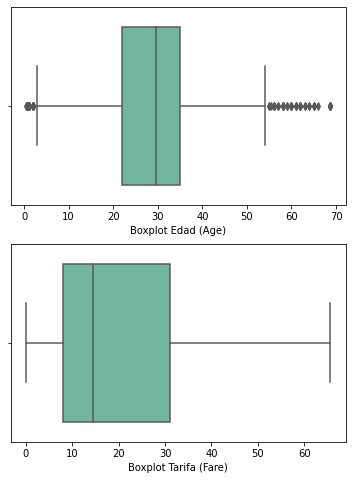

In [ ]:
# Tendencia central y dispersión.
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

sns.boxplot(x="Age", data=data, ax=axs[0])
sns.boxplot(x="Fare", data=data, ax=axs[1])

axs[0].set_xlabel("Boxplot Edad (Age)")
axs[1].set_xlabel("Boxplot Tarifa (Fare)")

## 5.2. Precio del billete según el Sexo

Text(0.5, 1.0, 'Boxplot tarifa por sexo')

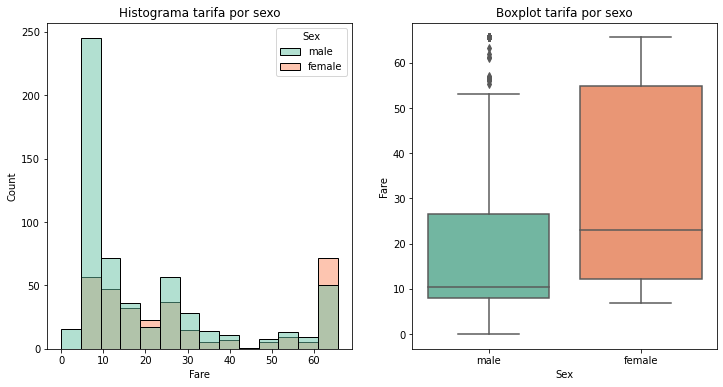

In [ ]:
# Precio del billete según el Sexo
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x="Fare", hue="Sex", data=data, ax=axs[0])
sns.boxplot(x="Sex", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Histograma tarifa por sexo")
axs[1].set_title("Boxplot tarifa por sexo")

## 5.3. Correlación Edad y Tarifa 

Text(0.5, 1.0, 'Scatter plot Tarifa vs Edad')

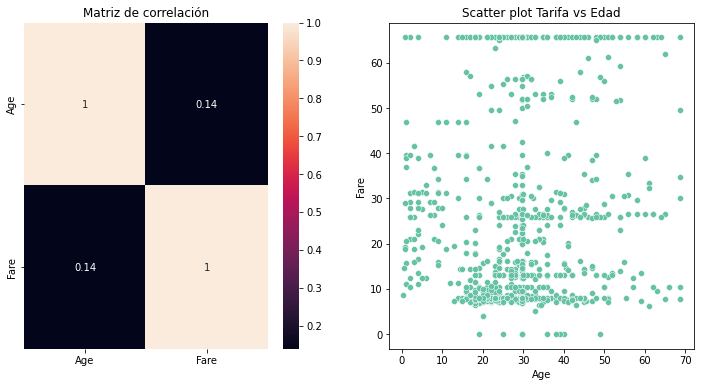

In [ ]:
# Correlación y dispersión
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(cor_matrix, annot=True, ax=axs[0])
sns.scatterplot(x="Age", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Matriz de correlación")
axs[1].set_title("Scatter plot Tarifa vs Edad")

# 5.4. Precio del billete según puerto de embarque.

Text(0.5, 1.0, 'Boxplot tarifa por puerto de embarque')

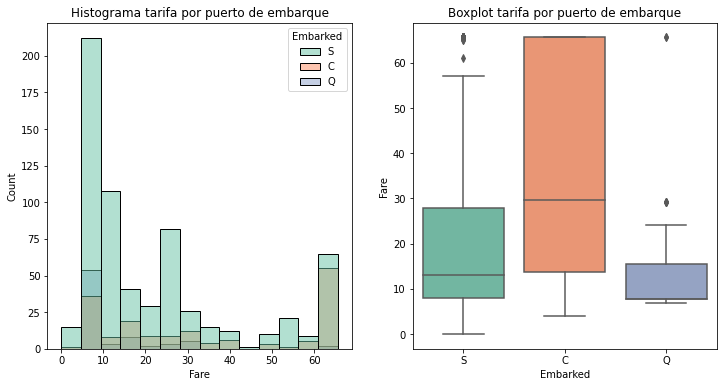

In [ ]:
# Precio del billete según puerto de embarque.
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x="Fare", hue="Embarked", data=data, ax=axs[0])
sns.boxplot(x="Embarked", y="Fare", data=data, ax=axs[1])

axs[0].set_title("Histograma tarifa por puerto de embarque")
axs[1].set_title("Boxplot tarifa por puerto de embarque")

# 6. Resolución del problema

A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?

# 7. Código

El código, así como el conjunto de datos se puede encontrar en el siguiente repositorio GitHub:

